In [10]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\sbp_toy_abm")

In [11]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from calibrated_abm.model import FLCalibratedABM

In [12]:
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [41]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Model initialization, step and collection of outputs

Import data on farmers and farms

In [14]:
farmers_data = ".\data\FarmersData.xlsx"
farms_data = ".\data\FarmsData.xlsx"

Provide payments for SBP adoption

In [15]:
# Give payments in €/hectare, one entry for each year 
sbp_payments = [50.72, 50.72, 51.82]
payments = {"Sown Permanent Pasture": sbp_payments}

Provide costs for pastures

In [16]:
pastures_costs = {"Sown Permanent Pasture": {
                    "installation": [-722.97],
                    "maintenance": [0.00, -135.96, 0.00, -318.27, 0.00,
                                    -135.96, 0.00, -318.27, 0.00]
                          },
                  'Natural Pasture': {
                      "installation": [0.],
                      "maintenance": [-235.40, -210.18, -210.18, -210.18,
                                      -210.18, -235.40, -210.18, -210.18, 
                                      -210.18]
                      }
                  }

Provide weights of the best model found

In [17]:
weights = (1.25, 0.75, -0.5, 0.25)

Initialize and run one step

In [18]:
# Note that the model is initialized with a seed to have the same results
model = FLCalibratedABM(weights, payments, pastures_costs)

In [19]:
model.step()

Retrieve adoption at the farmer level

In [20]:
adoption_output = model.datacollector.get_agent_vars_dataframe()

In [21]:
final_adoption = adoption_output.loc[max(adoption_output.index.get_level_values(0).tolist())]
final_adoption = final_adoption.set_index('FARM_ID')
final_adoption.head()

,Pasture,Confidence factor,Differential ENPV SBP
FARM_ID,,,
PT02,Natural Pasture,0.436583,-212.515505
PT13,Sown Permanent Pasture,0.990655,249.982460
PT15,Sown Permanent Pasture,1.155911,387.926273
PT16,Natural Pasture,0.583333,-90.019350
PT17,Sown Permanent Pasture,1.152066,384.716436


Retrieve adoption at the aggregated level

In [22]:
aggregate_adoption = model.datacollector.get_model_vars_dataframe()
aggregate_adoption

,Percentage of adoption
0,76.666667


# Results analysis

<AxesSubplot:>

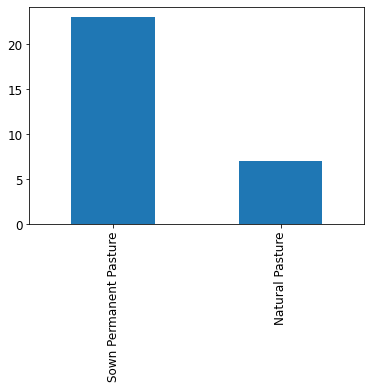

In [23]:
pd.value_counts(final_adoption['Pasture']).plot.bar()

In [24]:
final_adoption['Confidence factor'].describe()

count    30.000000
mean      1.034443
std       0.497939
min      -0.202463
25%       0.716492
50%       0.969523
75%       1.360368
max       1.979942
Name: Confidence factor, dtype: float64

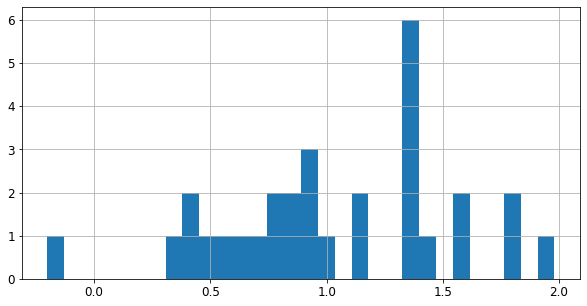

In [35]:
ax = final_adoption['Confidence factor'].hist(bins=30, figsize=(8, 4))


Saving figure EDNPV


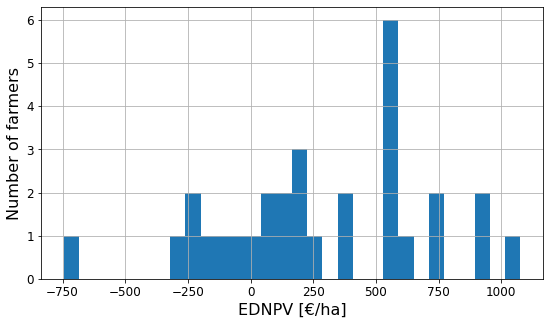

In [44]:
ax = final_adoption['Differential ENPV SBP'].hist(bins=30, figsize=(9, 5))
ax.set_xlabel("EDNPV [€/ha]", fontsize=16)
ax.set_ylabel("Number of farmers", fontsize=16)
save_fig('EDNPV')

# Model validation

Get real adoption data

In [27]:
real_adoption_path = ".\data\FarmsDataValidation.xlsx"
real_adoption = pd.read_excel(real_adoption_path, index_col=0)
real_adoption.head()

,Pasture
FARM_ID,
PT02,Natural Pasture
PT13,Sown Permanent Pasture
PT15,Sown Permanent Pasture
PT16,Natural Pasture
PT17,Sown Permanent Pasture


<AxesSubplot:>

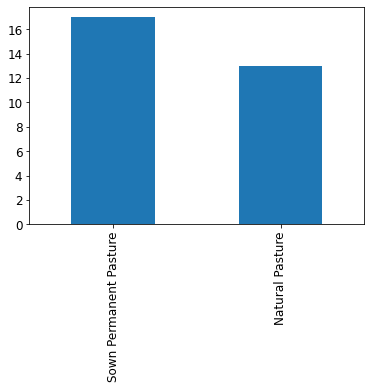

In [28]:
pd.value_counts(real_adoption['Pasture']).plot.bar()

## Micro-level validation

In [29]:
import sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [30]:
pred_adoption = final_adoption['Pasture']

In [31]:
# Ordered in the right way: the first, Natural Pature, is considered the negative class
confusion_matrix(real_adoption, pred_adoption)

array([[ 6,  7],
       [ 1, 16]], dtype=int64)

In [32]:
print('Precision:', precision_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))
print('Recall:', recall_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))
print('F1 score:', f1_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))

Precision: 0.6956521739130435
Recall: 0.9411764705882353
F1 score: 0.7999999999999999


## Macro-level validation

In [33]:
real_farmers_adopted = real_adoption['Pasture'].value_counts()['Sown Permanent Pasture']
real_percentage_adoption = real_farmers_adopted / len(real_adoption['Pasture'])*100
print(real_farmers_adopted, real_percentage_adoption)

17 56.666666666666664


In [34]:
modelled_percentage_adoption = aggregate_adoption.iloc[0, 0]
num_adopters = sum(pas == "Sown Permanent Pasture" for pas in final_adoption['Pasture'])
print(num_adopters, modelled_percentage_adoption)

23 76.66666666666667
